In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# load data
data = pd.read_csv('hotel_reviews.csv')

# drop unnecessary columns
data = data.drop(columns=['address', 'country', 'name', 'postalCode', 'reviews_dateAdded',
             'reviews_id', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_username',
             'reviews_userProvince', 'reviews_doRecommend'])

# filter city/category to top 10 and other for rest
top_cities = data['city'].value_counts().nlargest(10).index
data['city'] = data['city'].apply(lambda x: x if x in top_cities else 'Other')

top_categories = data['categories'].value_counts().nlargest(10).index
data['categories'] = data['categories'].apply(lambda x: x if x in top_categories else 'Other')

# get date features
data['reviews_date'] = pd.to_datetime(data['reviews_date'], errors='coerce')
data['review_year'] = data['reviews_date'].dt.year
data['review_month'] = data['reviews_date'].dt.month
data = data.drop(columns=['reviews_date'])

# One-hot encoding the categorical features
data = pd.get_dummies(data, drop_first=True, dtype=int)

# drop any rows with NaNs
data = data.dropna()

X = data.drop(columns=['reviews_rating']).values

# make reviews rating into 1 if the star rating is 4 or 5 
# make it 0 if it is below 4, good and bad ratings
y = (data['reviews_rating'] >= 4).astype(int).values

# min-max scaling
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

# add intercept/bias column to X
Phi = np.hstack((np.ones((X_scale.shape[0], 1)), X_scale))

# Separating data into training and test sets
[X_train, X_test, y_train, y_test] = train_test_split(Phi, y, test_size = .3)

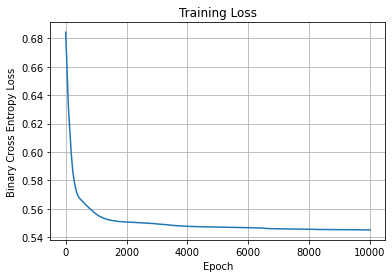

Accuracy: 0.712


In [7]:
# convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

class NN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.output(x))
        return x

model = NN(X_train_tensor.shape[1])

# Binary Cross Entropy seems to bbe the same as the log loss objective function we use
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10000

# keep track of gradient descent errors
# to monitor convergence
errors = []

# gradient descent
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    errors.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(range(epochs), errors)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("Training Loss")
plt.show()


In [ ]:
# predict using the test data  and evaluate the accuracy of the algorithm
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred_class = (y_test_pred > 0.5).float()

    accuracy = accuracy_score(y_test_tensor.numpy(), y_test_pred_class.numpy())
    print(f'Accuracy: {accuracy:.3f}')

add f1 and f1 plots